# Angle-based Outlier Detector (ABOD)

----

**Created by**:

- **Author**: Dr. Saad Laouadi
- **Date**: 07/08/2024

This notebook was created by dr. Saad Laouadi on August 7th, 2024 as part of a series on anomaly detection algorithms. The content is designed for researchers, data scientists, and practitioners interested in applying the ABOD algorithm to identify anomalies in diverse datasets.

**Copyright**

**© 2024 Dr. Saad Laouadi. All rights reserved.**

---

**Pre-requisites:**

This notebook assumes a foundational understanding of Python tools for data manipulation and processing. The following prerequisites will help you get the most out of this material:

1. **Data Manipulation**:
   - Familiarity with reading and writing data using libraries such as **Pandas** and **NumPy**.

2. **Machine Learning Workflow**:
   - Prior experience with the **Scikit-learn** library, including:
     - Preprocessing techniques like scaling and normalization.
     - Splitting data into training and test sets using tools like `train_test_split`.

3. **Data Visualization**:
   - Proficiency in using plotting libraries such as **Matplotlib** and **Seaborn** for visualizing data and model results.

## Table of Contents

1. [Objective](#Objective)
2. [Introduction to ABOD](#Introduction-to-ABOD)
   - 2.1. [Theory and Background](#Theory-and-Background)
   - 2.2. [Why Use ABOD?](#Why-Use-ABOD)
3. [Steps for Training the ABOD Algorithm](#Steps-for-Training-the-ABOD-Algorithm)
   - 3.1. [Data Preprocessing](#Data-Preprocessing)
   - 3.2. [Algorithm Initialization](#Algorithm-Initialization)
   - 3.3. [Model Training](#Model-Training)
   - 3.4. [Model Evaluation](#Model-Evaluation)
4. [Artificial Example with Simulated Data](#Artificial-Example-with-Simulated-Data)
   - 4.1. [Generating Simulated Data](#Generating-Simulated-Data)
   - 4.2. [Training ABOD on Simulated Data](#Training-ABOD-on-Simulated-Data)
   - 4.3. [Results and Visualization](#Results-and-Visualization)
5. [Real-World Example](#Real-World-Example)
   - 5.1. [Dataset Introduction](#Dataset-Introduction)
   - 5.2. [Preprocessing the Real-World Data](#Preprocessing-the-Real-World-Data)
   - 5.3. [Applying ABOD to Real-World Data](#Applying-ABOD-to-Real-World-Data)
   - 5.4. [Analyzing Results](#Analyzing-Results)
6. [Testing ABOD on Multiple Datasets](#Testing-ABOD-on-Multiple-Datasets)
   - 6.1. [Overview of Datasets](#Overview-of-Datasets)
   - 6.2. [Batch Testing and Performance Evaluation](#Batch-Testing-and-Performance-Evaluation)
   - 6.3. [Summary of Results](#Summary-of-Results)
7. [Conclusion](#Conclusion)
8. [References](#References)

In [18]:
# ============================================================================================# 
#                         Environment Setup
#  Here we import all the necessary modules and tools we will use through this notebook
# ============================================================================================# 

import numpy as np 
import pandas as pd
from scipy.io import arff

from sklearn.preprocessing import StandardScaler, LabelEncoder
from pyod.models.abod import ABOD

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns

# The utils module is not an installable package, it is the same directory as this notebook
from utils import generate_data, visualize_data, apply_abod, apply_abod_advanced, precision_at_rank_n
from utils import grid_search_abod, hyperopt_objective

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll.base import scope

## Objective

The primary objective of this notebook is to provide a comprehensive understanding of the **Angle-based Outlier Detector (ABOD)** algorithm, including its theoretical foundation, practical implementation, and evaluation. We will explore both artificial and real-world examples to demonstrate the algorithm's capabilities in detecting outliers in various datasets.

## Introduction to ABOD

### Theory and Background

The Angle-based Outlier Detector (ABOD) algorithm is a powerful technique for detecting anomalies in high-dimensional datasets. It operates by examining the variance of angles between a point and all other pairs of points in the dataset. Points with a low variance in angles are more likely to be outliers, as they exhibit an unusual spatial relationship with other data points.

ABOD stands for Angle-Based Outlier Detection. It’s an anomaly detection algorithm that uses the angle variance between a data point and its neighbors to determine how much of an outlier the point is. The intuition behind ABOD is that outliers will have a higher variance in the angles to their neighbors compared to normal points.


It is based on the concept of the angle-based outlier factor (ABOF), which measures the outlierness of a data point based on the angles between the vector connecting the point to its neighbors and the other vectors connecting the point to its neighbors.

### How ABOD Works
The ABOD algorithm works as follows:

1. **Compute the Angle-Based Outlier Factor (ABOF)**: For each data point x, the ABOD algorithm computes the ABOF, which is defined as the variance of the angles between the vector connecting x to its neighbors and the other vectors connecting x to its neighbors. The ABOF is calculated as follows:
$$ABOF(x) = Var(θ(x, x_i, x_j)) \qquad \text{for all} \quad x_i, x_j ∈ N(x)$$
where: $N(x)$ is the set of neighbors of $x$, and $θ(x, x_i, x_j)$ is the angle between the vector connecting $x$ to $x_i$ and the vector connecting $x$ to $x_j$.

2. **Rank the Data Points**: The data points are then ranked in descending order based on their ABOF values, with the highest ABOF values indicating the most likely outliers.

3. **Define the Outlier Threshold**: The user or the algorithm can define a threshold for the ABOF values, and data points with ABOF values above the threshold are considered outliers.

### Why Use ABOD?

ABOD is particularly useful in scenarios where traditional distance-based methods struggle to identify outliers due to the curse of dimensionality. It offers robustness against the challenges posed by high-dimensional data, making it a valuable tool for anomaly detection in complex datasets.

## Steps for Training the ABOD Algorithm

### Data Preprocessing

Preprocessing is a critical step in training the ABOD algorithm. It involves data cleaning, handling missing values, and scaling features to ensure that the algorithm can effectively analyze the data.

### Algorithm Initialization

The initialization phase involves setting up the ABOD model with appropriate parameters and configurations. This step includes choosing hyperparameters that align with the dataset's characteristics and the analysis objectives.

### Model Training

Model training involves fitting the ABOD algorithm to the dataset. This process examines the geometric relationships between points to identify potential outliers.

### Model Evaluation

Evaluating the model's performance is essential to validate its effectiveness. Metrics such as precision, recall, and ROC-AUC are used to assess how well the model distinguishes between normal and anomalous data points.

## Training ABOD with PYOD 

To train and ABOD model, you use the  the `ABOD` Class in pyod library which implements the Angle-Based Outlier Detection algorithm. It uses the variance of angles between a data point and its neighbors to detect outliers.

**Parameters**: The ABOD Has the following parameters:
  1. contamination: The proportion of outliers in the dataset.
      - float (default=0.1)
      - Range: (0, 0.5)
      - Used to define the threshold on the decision function.
  2. n_neighbors: The number of neighbors to use for k-neighbors queries.
      - int (default=5)
  3. method: str (default='fast')
        - The method to use for ABOD.
        - Options:
              - 'fast': Fast ABOD, which uses n_neighbors nearest neighbors to approximate the outlier score.
              - 'default': Original ABOD, which considers all training points and has a higher time complexity.

**Methods**: The `ABOD` class has several methods, here is the main ones:
  1. **fit()** method: Fits the `ABOD` model to the training data. This method has the following parameter:
       - **X_train**: The training data which is ndarray of shape (n_samples, n_features)
       - You can implement it like this:
          ```python
          abod_model.fit(X_train)
          ```
  2. **predict** method: it Predicts binary labels (outlier or inlier) for the input data. It takes
        - **X_test**: The input data to predict, which is an ndarray of shape (n_samples, n_features)
	    - It returns: Binary labels for each data point (0 for inliers, 1 for outliers), which is an ndarray of shape (n_samples,)
        - It is implemented like this: `y_pred = abod_model.predict(X_test)`
  3. **decision_function**: It returns the outlier scores for the input data.
      - It takes: The input data to score `X_test`.
      - It returns: Outlier scores for each data point. Higher scores indicate a higher likelihood of being an outlier. This object is an ndarray of shape (n_samples,)
      - It is implemented like this: `outlier_scores = decision_function(X_test)`


### Training `ABOD` Workflow

Here is the detailed steps into training an `ABOD` model:

1. **Importing the ABOD Class**: To use the ABOD class, you need to import it from the pyod.models.abod module:
    ```python
    from pyod.models.abod import ABOD
    ```
2. **Initializing the ABOD Detector**: You can create an instance of the ABOD class by initializing it with various parameters:
    ```python
    abod = ABOD(contamination=0.1, n_neighbors=5, method='fast')
    ```
3. **Train the model**: You can train the model by calling the `fit` method:
    ```python
    abod.fit(X_train)
    ```
4. **Make predictions**: Call the `predict` method to make predictions
   ```python
   y_pred = abod.predict(X_test)
   ```
5. **Get outlier Scores**: Use the `decision_function` to get the outlier scores
   ```python
   outlier_scores = abod.decision_function(X_test)
   ```

### Example Workflow

Here is a complete example of training an `ABOD` model. We will generate random data, and later sections we will use actual data.

In [2]:
# Example to train a simple ABOD model Using randomly generated data
# In the pyod library, there is a function `generate_data`, I am using it here
# for simplicity purposes

# 1. Generate some sample data
np.random.seed(42)
X = np.random.randn(100, 2)

# 2. Introduce some outliers
X[:10] = np.random.uniform(low=-6, high=6, size=(10, 2))

# 3. Split the data into training and testing sets
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# 4. Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Initialize the ABOD detector
abod = ABOD(contamination=0.1, n_neighbors=10, method='fast')

# 6. Fit (train) the model
abod.fit(X_train_scaled)

# 7. Predict the labels
y_pred = abod.predict(X_test_scaled)


# Get outlier scores
outlier_scores = abod.decision_function(X_test_scaled)


print(f"The train data shape: {X_train.shape}")
print(f"The test data shape: {X_test.shape}\n")
print("Predicted labels:\n", y_pred)
print("Outlier scores:", outlier_scores)

print(f"\nThe predicted labels shape: {y_pred.shape}")
print(f"The outlier scores shape: {outlier_scores.shape}")

The train data shape: (80, 2)
The test data shape: (20, 2)

Predicted labels:
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0]
Outlier scores: [-3.50470854e+00 -1.78769896e+00 -3.72700058e+01 -6.94172818e+01
 -7.68172540e+01 -2.20799081e+00 -3.85792145e+00 -4.52325604e+01
 -6.10799287e+00 -9.33027055e-03 -4.06573428e+00 -1.30646128e+02
 -1.11348426e+00 -3.05227671e+01 -5.88957719e+01 -6.98700981e-03
 -3.43998101e+01 -1.48284429e+02 -3.64168060e+01 -4.90211693e+00]

The predicted labels shape: (20,)
The outlier scores shape: (20,)


## Artificial Example with Simulated Data
In the previous section, we introduced how to train an `ABOD` model, in this section, we simulate some random data and train a model to enhance understanding of the algorithm. 

### Generating Simulated Data

In this section, we generate synthetic datasets that mimic real-world data distributions. These datasets provide a controlled environment for testing the ABOD algorithm's ability to detect outliers.

### Training ABOD on Simulated Data

We apply the ABOD algorithm to the simulated datasets, adjusting parameters and settings to optimize its performance.

### Results and Visualization

The results of the simulation are visualized using various plots to illustrate how ABOD identifies anomalies within the data.

Before being a data scientist, I am programer, so I prefer using modular code instead of jotting lines of codes here and there. Therefore, I have written a `utils` module that contains utility functions to ease out the steps of training different outlier detection algorithms. Here we will be using `apply_abod_advanced` function, which helps us train and visualize the results at once. It also allows us to print different evaluation metrics. 

In [3]:
# This is a simple example, you can uncomment to check the output
# # Step 01: Generate synthetic data
# X, y = generate_data()
# print(X.shape) 
# print(y.shape)

# # step 02: Plot the generated data
# visualize_data(X, y)

# # Step 3: Apply ABOD algorithm and analyze the results
# apply_abod(X, y, contamination=0.1)

In this example:
  1. We generate synthetic data
  2. Train abod model using our customized function
  3. Plot the results of the trained model
  4. Print different evaluation metrics.

The code is well commented bellow:

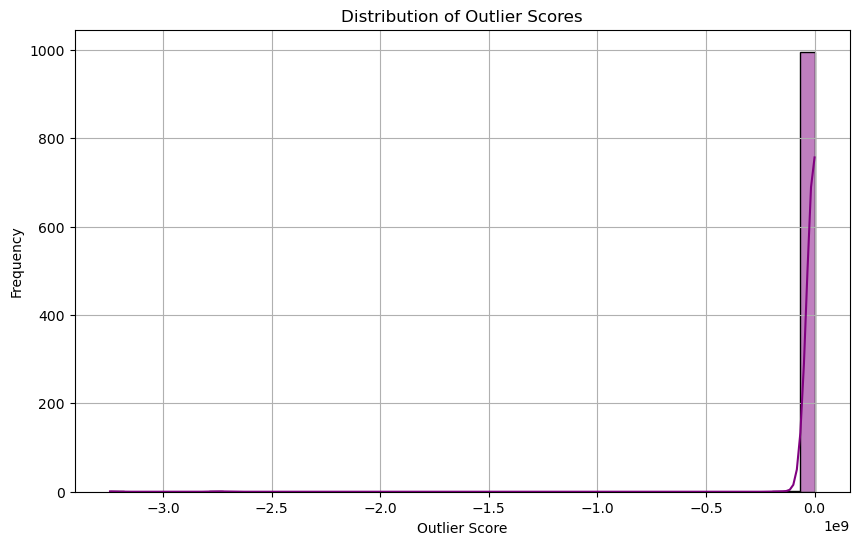

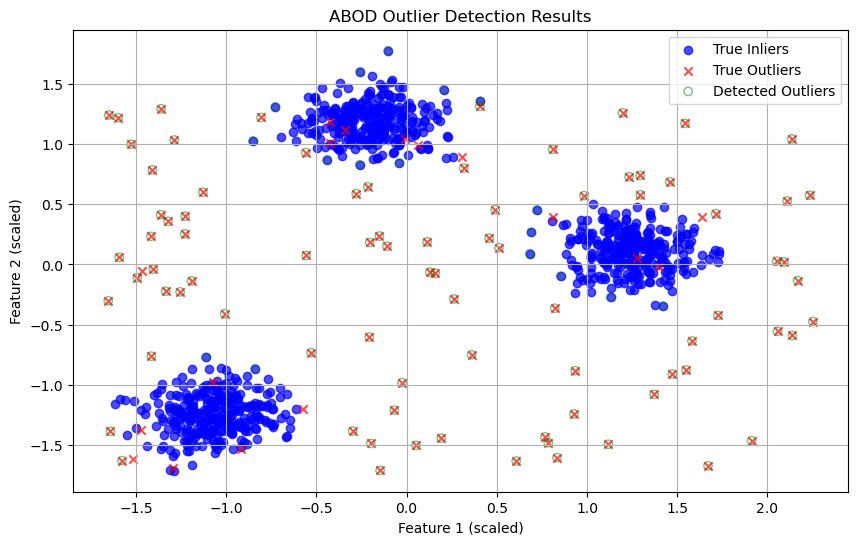

ROC AUC: 0.9580666666666667
Precision-Recall AUC: 0.8504840122234182
Classification Report:
               precision    recall  f1-score   support

      Inlier       0.98      0.98      0.98       900
     Outlier       0.83      0.83      0.83       100

    accuracy                           0.97      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.97      0.97      0.97      1000

Precision at Rank n: 0.83


In [4]:
# Step 1: Generate synthetic data
X, y = generate_data(n_samples=1000, n_features=2, n_inliers=900, n_outliers=100)

# Step 2: Apply ABOD with customized options
results = apply_abod_advanced(
    X, y,
    contamination=0.1,                   # Proportion of data expected to be outliers
    scale_data=True,                     # Whether to scale the data
    scaler_type='standard',              # Type of scaler to use ('standard' or 'minmax')
    plot_scores=True,                    # Whether to plot the distribution of outlier scores
    plot_outliers=True,                  # Whether to plot the detected outliers
    n=100,                              # Number of outliers for precision calculation (None uses actual number of outliers)
    abod_params={'n_neighbors': 10},     # Parameters for the ABOD model
    plot_params={'color': 'purple'}      # Parameters for plotting
)

# Step 3: Access and print the results
print("ROC AUC:", results['roc_auc'])
print("Precision-Recall AUC:", results['pr_auc'])
print("Classification Report:\n", results['classification_report'])
print("Precision at Rank n:", results['precision_at_rank_n'])

---

## Real-World Example
This section introduces a real-world dataset chosen for analysis with the ABOD algorithm. We use a famous dataset used in outlier detection benchmark research, HeartDisease dataset. You can access the data from here [data source](https://www.dbs.ifi.lmu.de/research/outlier-evaluation/DAMI/semantic/HeartDisease/HeartDisease_44.html)

### Dataset Introduction: HeartDisease (44% of outliers)

The Hear disease dataset contains medical data on heart problems. Affected patients are considered outliers and healthy people are considered inliers.

### Workflow

To train ABOD model we will follow the next steps:
 1. **Preprocessing the dataset**: We ensure the following:
      - Handling missing data if any
      - Handling duplicates
      - Encoding categorical features and/or the target
      - Scaling the features

 2. **Applying ABOD**: Training the ABOD on the preprocessed data.

 3. **Evaluation the results**: Assess the ABOD performance using different metrics such as precision at rank n.

 4. **Analyzing Results**: Since this notebook objective to provide a detailed explanation of the algorithm, we analyze the results carefully, focusing on the insights gained from identifying anomalies and their implications for the dataset's domain.

> **Note**
> To be able to reproduce the results of the following example, you need to download the dataset first and save it in a convenient directory.



In [5]:
# I have already downloaded the data a save it a directory named `datasets` 
# This directory is not available on my github due to its big size. 

# Load ARFF file
data, meta = arff.loadarff('../../datasets/HeartDisease/HeartDisease_withoutdupl_norm_44.arff')

# Convert to Pandas DataFrame
df = pd.DataFrame(data)

# Display the first few rows
print(df.head())
print(df.info())

    id       Age  Sex  ChestPainType  RestBloodPressure  SerumCholestoral  \
0  1.0  0.854167  1.0       1.000000           0.339623          0.447489   
1  2.0  0.791667  0.0       0.666667           0.198113          1.000000   
2  3.0  0.583333  1.0       0.333333           0.283019          0.308219   
3  4.0  0.729167  1.0       1.000000           0.320755          0.312785   
4  5.0  0.937500  0.0       0.333333           0.245283          0.326484   

   FastingBloodSugar  ResElectrocardiographic  MaxHeartRate  ExerciseInduced  \
0                0.0                      1.0      0.290076              0.0   
1                0.0                      1.0      0.679389              0.0   
2                0.0                      0.0      0.534351              0.0   
3                0.0                      0.0      0.259542              1.0   
4                0.0                      1.0      0.381679              1.0   

    Oldpeak  Slope  MajorVessels  Thal outlier  
0  0.38

In [6]:
# Check for duplicates
print("The n duplicates:", df.duplicated().sum())     # Already know that data has now duplicates

# Check missing data
print(df.isnull().sum())   # already obvious based on the previous result of info method.

The n duplicates: 0
id                         0
Age                        0
Sex                        0
ChestPainType              0
RestBloodPressure          0
SerumCholestoral           0
FastingBloodSugar          0
ResElectrocardiographic    0
MaxHeartRate               0
ExerciseInduced            0
Oldpeak                    0
Slope                      0
MajorVessels               0
Thal                       0
outlier                    0
dtype: int64


In [7]:
# Describe the dataset
print(df.iloc[:, 1:].describe().T)

                         count      mean       std  min       25%       50%  \
Age                      270.0  0.529861  0.189772  0.0  0.395833  0.541667   
Sex                      270.0  0.677778  0.468195  0.0  0.000000  1.000000   
ChestPainType            270.0  0.724691  0.316697  0.0  0.666667  0.666667   
RestBloodPressure        270.0  0.352306  0.168506  0.0  0.245283  0.339623   
SerumCholestoral         270.0  0.282327  0.118005  0.0  0.198630  0.271689   
FastingBloodSugar        270.0  0.148148  0.355906  0.0  0.000000  0.000000   
ResElectrocardiographic  270.0  0.511111  0.498946  0.0  0.000000  1.000000   
MaxHeartRate             270.0  0.600594  0.176838  0.0  0.473282  0.629771   
ExerciseInduced          270.0  0.329630  0.470952  0.0  0.000000  0.000000   
Oldpeak                  270.0  0.143548  0.177483  0.0  0.000000  0.064516   
Slope                    270.0  0.292593  0.307195  0.0  0.000000  0.500000   
MajorVessels             270.0  0.223457  0.314632  

**From the previous results it seems the data already scaled, therefore we will not apply scaling.**

In [8]:
# Convert the 'outlier' column to a binary format
# 'yes' indicates outliers (1) and 'no' indicates inliers (0)
label_encoder = LabelEncoder()
df['outlier'] = label_encoder.fit_transform(df['outlier'])

In [9]:
df['outlier'].value_counts()

outlier
0    150
1    120
Name: count, dtype: int64

In [10]:
# Separate features (X) and target (y)
X = df.drop(columns=['id', 'outlier'])
y = df['outlier']

In [11]:
print(X.shape)
print(y.shape)

# The outlier contamination percentage
print(len(y[y==1])/len(y))

(270, 13)
(270,)
0.4444444444444444


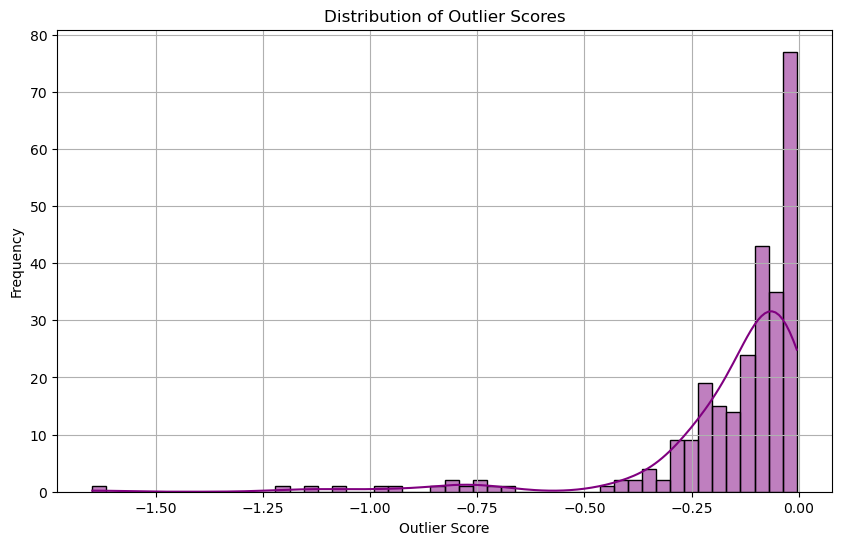

In [12]:
# Train ABOD with customized options
results = apply_abod_advanced(
    X, y,
    contamination=0.44,                     # Proportion of data expected to be outliers
    scale_data=False,                        # Whether to scale the data
    # scaler_type='standard',                 # Type of scaler to use ('standard' or 'minmax')
    plot_scores=True,                       # Whether to plot the distribution of outlier scores
    plot_outliers=False,                     # Whether to plot the detected outliers
    n=120,                                  # Number of outliers for precision calculation (None uses actual number of outliers)
    abod_params={'n_neighbors': 82},        # Parameters for the ABOD model (82 is based on this source: )
    plot_params={'color': 'purple'}         # Parameters for plotting
)

In [13]:
print("The ROC:", results['roc_auc'])
print("Classification report", results['classification_report'])
print("Precision at n: ", results['precision_at_rank_n'])

The ROC: 0.6484444444444445
Classification report               precision    recall  f1-score   support

      Inlier       0.64      0.64      0.64       150
     Outlier       0.55      0.54      0.54       120

    accuracy                           0.60       270
   macro avg       0.59      0.59      0.59       270
weighted avg       0.60      0.60      0.60       270

Precision at n:  0.55


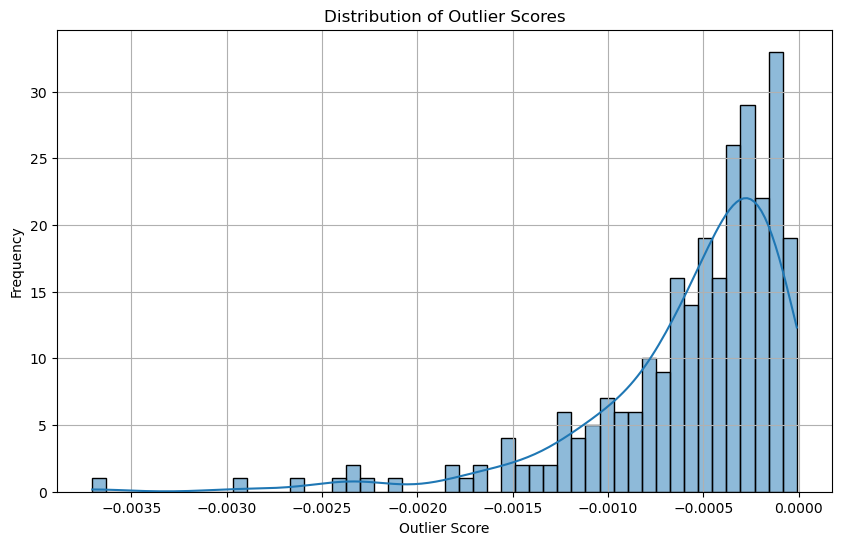

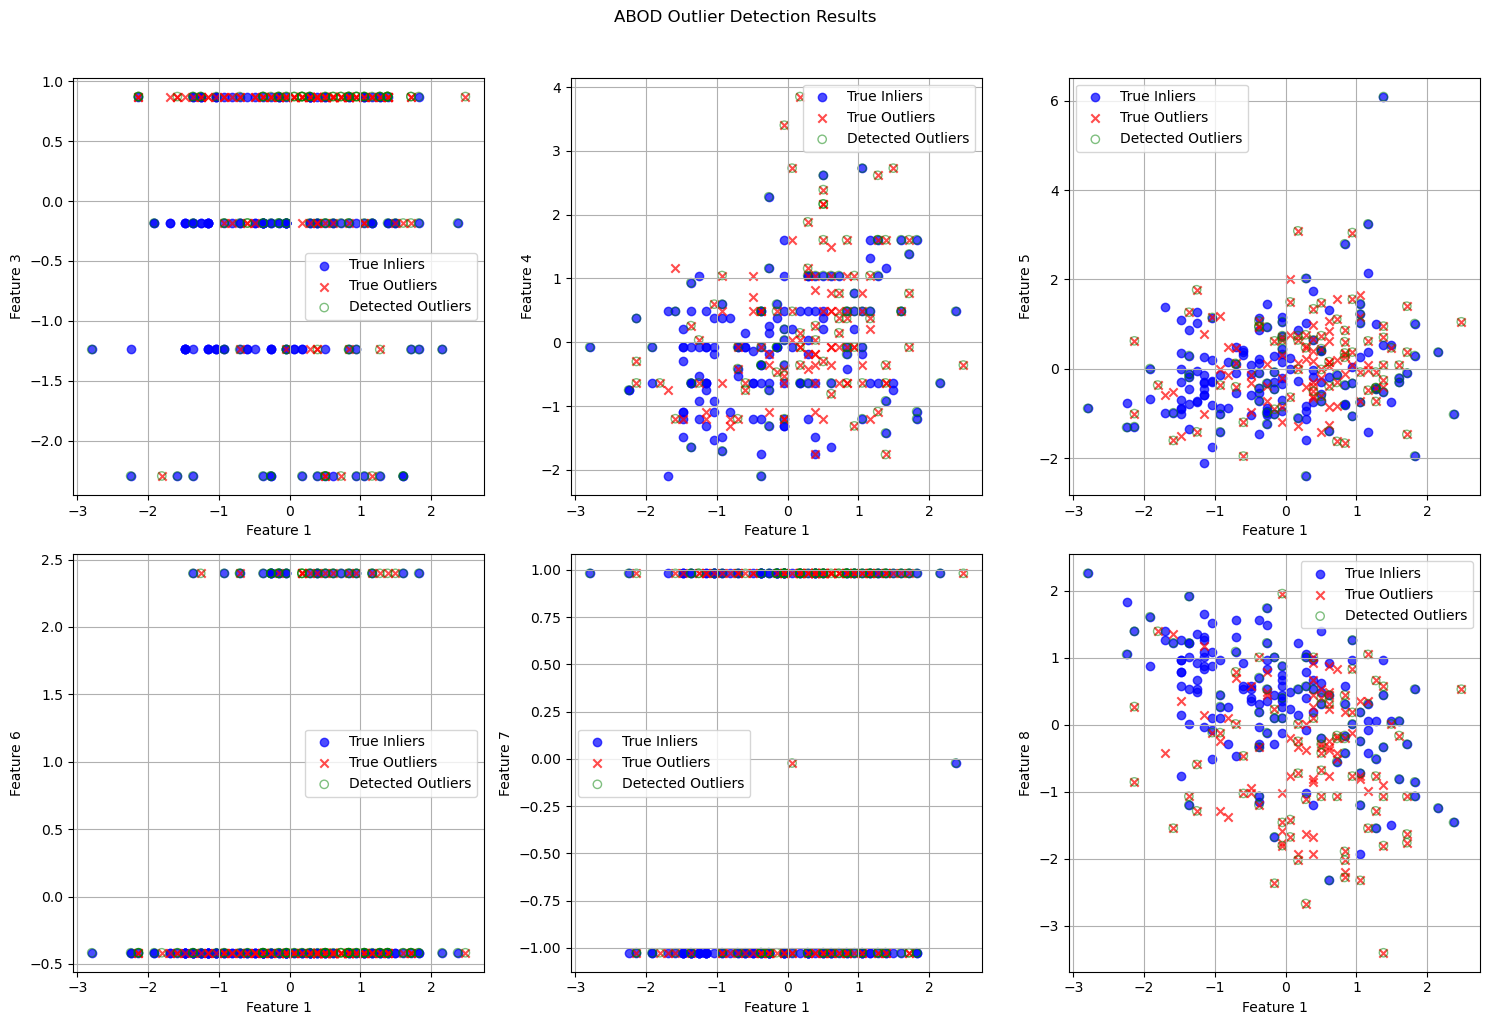

ROC AUC: 0.6520555555555555
Precision-Recall AUC: 0.5530216455736732
Classification Report:
               precision    recall  f1-score   support

      Inlier       0.64      0.64      0.64       150
     Outlier       0.55      0.54      0.54       120

    accuracy                           0.60       270
   macro avg       0.59      0.59      0.59       270
weighted avg       0.60      0.60      0.60       270

Precision at Rank n: 0.5416666666666666


In [14]:
# Assuming X and y are your data and labels
results = apply_abod_advanced(
    X, y,
    contamination=0.44,                     # Proportion of data expected to be outliers
    scale_data=True,                        # Whether to scale the data
    plot_scores=True,                       # Whether to plot the distribution of outlier scores
    plot_outliers=True,                     # Whether to plot the detected outliers
    n=120,                                  # Number of outliers for precision calculation (None uses actual number of outliers)
    abod_params={'n_neighbors': 82},        # Parameters for the ABOD model
    plot_params={'alpha': 0.5},             # Parameters for plotting
    plot_features=[0, 2, 3, 4, 5, 6, 7],   # Features to plot (main feature + other features)
    n_cols=3
)

print("ROC AUC:", results['roc_auc'])
print("Precision-Recall AUC:", results['pr_auc'])
print("Classification Report:\n", results['classification_report'])
print("Precision at Rank n:", results['precision_at_rank_n'])

In [15]:
# plot_matrix(X, y, y_pred)

### Fine-Tune ABOD Algorithm

In this section we will try to find the best hyperparameter `n-neighbors`, since we have prior information about the number of outliers. The best `n-neighbors` is determined based on the `precision at rank n` metric. 

We have written two functions to do perform the search, the first function is used to perform `grid_search` and the second one is based on hyperopt package. I assume you already have a background about hyperparameter tuning techniques, because they are beyond the scope of this notebook tutorial. 

In [16]:
# Perform grid search for hyperparameter tuning:
# =============================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the parameter grid for n_neighbors
n_neighbors_options = np.arange(2, 101)

# Known contamination rate
contamination = 0.4444

# Known number of outliers
n_outliers = 120

# Perform grid search to find the best n_neighbors
best_n_neighbors, best_precision_n = grid_search_abod(X_scaled,
                                                      y,
                                                      n_neighbors_options,
                                                      contamination,
                                                      n_outliers)

print(f"Best n_neighbors: {best_n_neighbors}")
print(f"Best precision at rank n: {best_precision_n:.2f}")

Best n_neighbors: 3
Best precision at rank n: 0.58


**This is the second try to find the best n-neighbors value**, we will use the `hyperopt` and objective function to perform this search:

In [20]:
from sklearn.preprocessing import StandardScaler
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll.base import scope

def precision_at_rank_n(y_true, y_scores, n=None):
    """
    Calculate precision at rank n for anomaly detection.

    Parameters
    ----------
    y_true : ndarray
        True binary labels for the dataset, where 1 indicates outliers and 0 indicates inliers.
    
    y_scores : ndarray
        Outlier scores for each sample, higher scores indicate higher likelihood of being an outlier.
    
    n : int, optional
        The number of top-ranked samples to consider for calculating precision. If None, it defaults to the number of actual outliers.
    
    Returns
    -------
    precision : float
        Precision at rank n.
    """
    if n is None:
        n = int(np.sum(y_true))  # Default to the number of actual outliers

    # Get indices of the top n scores
    top_n_indices = np.argsort(y_scores)[-n:]

    # Get the labels for the top n scores
    top_n_labels = y_true[top_n_indices]

    # Calculate precision at rank n
    precision = np.sum(top_n_labels) / n
    return precision

def objective(params):
    """
    Objective function for Hyperopt to optimize the n_neighbors parameter of ABOD.

    Parameters
    ----------
    params : dict
        Dictionary containing the hyperparameter 'n_neighbors'.

    Returns
    -------
    dict
        Dictionary containing the loss (negative precision at rank n) and the status.
    """
    n_neighbors = params['n_neighbors']
    
    # Initialize ABOD model with current n_neighbors
    abod = ABOD(n_neighbors=n_neighbors, contamination=contamination)

    # Fit the model to the data
    abod.fit(X_scaled)

    # Predict the outlier scores
    outlier_scores = abod.decision_scores_

    # Calculate precision at rank n
    precision_n = precision_at_rank_n(y, outlier_scores, n=n_outliers)
    
    return {'loss': -precision_n, 'status': STATUS_OK}


# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Known contamination rate
contamination = 0.4444

# Known number of outliers
n_outliers = int(contamination * len(y))

# Define the search space for n_neighbors
search_space = {
    'n_neighbors': scope.int(hp.quniform('n_neighbors', 5, 50, 1))
}

# Use Hyperopt to optimize the n_neighbors parameter
trials = Trials()
best = fmin(fn=objective,
            space=search_space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print(f"Best n_neighbors: {best['n_neighbors']}")

100%|██████████| 100/100 [00:54<00:00,  1.84trial/s, best loss: -0.5546218487394958]
Best n_neighbors: 44.0


## Testing ABOD on Multiple Datasets

### Overview of Datasets

We provide an overview of several datasets used to evaluate ABOD's performance across different domains and conditions.

### Batch Testing and Performance Evaluation

The ABOD algorithm is tested on each dataset, and performance metrics are calculated to compare its effectiveness across various scenarios.

### Summary of Results

A summary of the results is presented, highlighting key findings, patterns, and areas for further investigation.

## Conclusion

This notebook demonstrates the application of the **Angle-based Outlier Detector (ABOD)** algorithm across multiple contexts. Through theoretical exploration and practical implementation, we have showcased ABOD's strengths in detecting anomalies in both artificial and real-world datasets.

## References

### Academic Articles

1. **Kriegel, H.-P., Kröger, P., Schubert, E., & Zimek, A. (2008).** *Angle-Based Outlier Detection in High-dimensional Data*. In Proceedings of the 14th ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (pp. 444-452). ACM.  
   [DOI:10.1145/1401890.1401946](https://dl.acm.org/doi/10.1145/1401890.1401946)  
   - This is the original paper introducing the ABOD algorithm, detailing the method's approach to identifying outliers in high-dimensional spaces using angular relationships.

2. **Zimek, A., Schubert, E., & Kriegel, H.-P. (2012).** *A survey on unsupervised outlier detection in high-dimensional numerical data*. Statistical Analysis and Data Mining: The ASA Data Science Journal, 5(5), 363-387.  
   [DOI:10.1002/sam.11161](https://onlinelibrary.wiley.com/doi/abs/10.1002/sam.11161)  
   - This survey paper explores various unsupervised outlier detection methods, with insights into high-dimensional challenges, including discussions on ABOD.

3. **Schubert, E., Zimek, A., & Kriegel, H.-P. (2012).** *Local Outlier Detection Reconsidered: A Generalized View on Locality with Applications to Spatial, Video, and Network Outlier Detection*. Data Mining and Knowledge Discovery, 28(1), 190-237.  
   [DOI:10.1007/s10618-012-0300-z](https://link.springer.com/article/10.1007/s10618-012-0300-z)  
   - This paper provides a generalized view on local outlier detection methods, offering insights into various applications and theoretical foundations.

4. **Zhang, K., Hutter, M., & Jin, H. (2009).** *A new local distance-based outlier detection approach for scattered real-world data*. In Pacific-Asia Conference on Knowledge Discovery and Data Mining (pp. 813-822). Springer.  
   [DOI:10.1007/978-3-642-01307-2_87](https://link.springer.com/chapter/10.1007/978-3-642-01307-2_87)  
   - This paper discusses local distance-based outlier detection, offering an alternative perspective that complements the angle-based approach of ABOD.

5. **Breunig, M. M., Kriegel, H.-P., Ng, R. T., & Sander, J. (2000).** *LOF: Identifying Density-Based Local Outliers*. In Proceedings of the 2000 ACM SIGMOD International Conference on Management of Data (pp. 93-104). ACM.  
   [DOI:10.1145/342009.335388](https://dl.acm.org/doi/10.1145/342009.335388)  
   - Although focused on the Local Outlier Factor (LOF) method, this paper provides valuable insights into density-based outlier detection, which is often contrasted with angle-based methods.

6. **Hodge, V. J., & Austin, J. (2004).** *A survey of outlier detection methodologies*. Artificial Intelligence Review, 22(2), 85-126.  
   [DOI:10.1023/B:AIRE.0000045502.10941.a9](https://link.springer.com/article/10.1023/B:AIRE.0000045502.10941.a9)  
   - A comprehensive survey of outlier detection methodologies, this paper provides context for understanding where ABOD fits within the larger landscape of outlier detection techniques.

### Books

1. **Aggarwal, C. C., & Sathe, S. (2017).** *Outlier Ensembles: An Introduction*. Springer.  
   [Springer Link](https://link.springer.com/book/10.1007/978-3-319-54765-7)  
   - This book introduces the concept of outlier ensembles, covering various techniques for combining multiple anomaly detection models to improve accuracy and robustness. It is a valuable resource for researchers and practitioners interested in ensemble methods for anomaly detection.

2. **Han, J., Kamber, M., & Pei, J. (2011).** *Data Mining: Concepts and Techniques (3rd ed.)*. Elsevier.  
   [Elsevier Link](https://shop.elsevier.com/books/data-mining-concepts-and-techniques/han/978-0-12-381479-1)  
   - This comprehensive book covers the fundamental concepts and techniques in data mining, including chapters on anomaly detection. It is widely used as a textbook for data mining courses and a reference for researchers and professionals.

3. **Aggarwal, C. C. (2013).** *Outlier Analysis*. Springer.  
   [ISBN:978-1-4614-6395-6](https://link.springer.com/book/10.1007/978-3-319-47578-3)  
   - This book provides comprehensive coverage of various outlier detection methods, including a section on angle-based techniques. It is a great resource for understanding the broader context of outlier analysis.

4. **Tan, P.-N., Steinbach, M., & Kumar, V. (2005).** *Introduction to Data Mining*. Pearson.  
   [ISBN:978-0321321367](https://www.pearson.com/us/higher-education/program/Tan-Introduction-to-Data-Mining-1st-Edition/PGM207437.html)  
   - This textbook provides a foundational understanding of data mining techniques, including sections on outlier detection.

### Online Documentation and Resources

1. **PyOD: A Python Toolbox for Scalable Outlier Detection (2019).**  
   [GitHub Repository](https://github.com/yzhao062/pyod)  
   - PyOD is a comprehensive Python library for outlier detection. The library implements the ABOD algorithm and provides documentation and examples for practical applications.

2. **PyOD Documentation**  
   [PyOD Documentation](https://pyod.readthedocs.io/en/latest/)  
   - The PyOD documentation provides practical examples and usage details for applying the ABOD algorithm and other outlier detection methods in Python.

3. **Wikipedia Article on Outlier Detection**  
   [Outlier Detection - Wikipedia](https://en.wikipedia.org/wiki/Anomaly_detection)  
   - This Wikipedia article gives an overview of anomaly detection techniques, including angle-based methods like ABOD.


### Additional Resources

- **Medium: Anomaly Detection Techniques: A Comprehensive Guide with Supervised and Unsupervised Learning**  
  [Medium](https://medium.com/@venujkvenk/anomaly-detection-techniques-a-comprehensive-guide-with-supervised-and-unsupervised-learning-67671cdc9680)  
  - This article provides a comprehensive guide on anomaly detection techniques, covering both supervised and unsupervised learning methods with practical examples.

- **Data Head Hunters: How to Use Python for Anomaly Detection in Data: Detailed Steps**  
  [Data Head Hunters](https://dataheadhunters.com/academy/how-to-use-python-for-anomaly-detection-in-data-detailed-steps/)  
  - This article provides a detailed guide on using Python for anomaly detection, covering the necessary steps and offering practical examples to implement various techniques.

- **Analytics Vidhya: An Awesome Tutorial to Learn Outlier Detection in Python using PyOD Library**
  [Analytics Vidhya](https://www.analyticsvidhya.com/blog/2019/02/outlier-detection-python-pyod/)  
  - A blog post exploring outlier detection techniques using PyOD, including the ABOD algorithm, with Python code examples and insights into practical applications.

- **Coursera: Anomaly Detection in Machine Learning**  
  [Coursera](https://www.coursera.org/articles/anomaly-detection-machine-learning)  
  - This article on Coursera provides an overview of anomaly detection in machine learning, discussing various techniques, their applications, and the importance of anomaly detection in different domains.

- **Analytics Vidhya: Learning Different Techniques of Anomaly Detection**  
  [Analytics Vidhya](https://www.analyticsvidhya.com/blog/2023/01/learning-different-techniques-of-anomaly-detection/)  
  - This article explores various anomaly detection techniques, offering insights into different algorithms and practical tips for implementing these methods in real-world scenarios.